In [37]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
%matplotlib inline
import random
import numpy as np

In [38]:
#A nagy téglalap méretei
a, b = 3, 5

#A kis téglalapok
rects = [(4, 4), (2, 3), (3, 3), (4, 5), (1, 6), (3, 3), (1, 8), (1, 10), (2, 7), (3, 5)]

#Egyszerűsítsük a problémát: Dobjuk ki azokat a "kisebb" téglalapokat, amik nem illeszthetők kilógás nélkül a "nagyobba"
rects = [r for r in rects if r[0] <= a and r[1] <= b]
#Nézzük meg, mi maradt
print(rects)

n = len(rects)

#Alább az egyes egyedek, majd a teljes populáció felépítése következik

rs = random.Random(142)

lb, ub = [], []
for i in range(n):
    lb.extend([0, 0, 0])
    ub.extend([a - rects[i][0], b - rects[i][1], 1])

#Generáljunk egy egyedet a populációból...  
def generate_sample(rs):
    #...véletlenszerűen
    x0 = [rs.randint(lb[i], ub[i]) for i in range(3 * n)]        
    return x0

[(2, 3), (3, 3), (3, 3), (3, 5)]


([1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0], None)

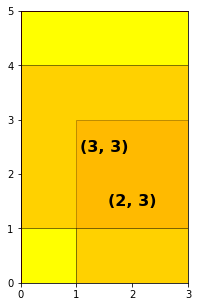

In [39]:
#Szükségünk lesz a megoldások vizualizálására
def plot_area(x0):
    fig,ax = plt.subplots(1, figsize=(a, b))
    r = patches.Rectangle((0, 0), a, b, linewidth=1, edgecolor='r', 
                          facecolor='yellow' #A nagy téglalap alapszíne, ezzel a színnel fognak szerepelni a le nem fedett részek
                          )
    ax.add_patch(r);
    ax.set_xlim(0, a)
    ax.set_ylim(0, b)
    for i in range(n):
        if x0[3 * i + 2] == 1:
            r0 = patches.Rectangle((x0[3 * i], x0[3 * i + 1]), rects[i][0], rects[i][1], 
                                   linewidth=1, 
                                   edgecolor='k', 
                                   facecolor='orange', #Jegyezzük meg ezt is, ez lesz a mindenkori lefedett területek színe
                                   alpha=0.5)
            ax.add_patch(r0)
            rx, ry = r0.get_xy()
            cx = rx + r0.get_width()/2.0
            cy = ry + r0.get_height()/2.0
            ax.annotate('(%i, %i)' % (rects[i][0], rects[i][1]), (cx, cy), color='k', weight='bold', fontsize=16, ha='center', va='center')

#Hozzunk létre egy példányt, és ábrázoljuk
x0 = generate_sample(rs)
x0, plot_area(x0)  

(11.0, 15, -29.0)

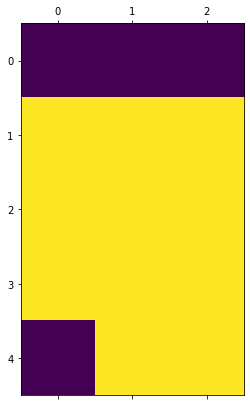

In [40]:
#Egy mátrixot 0 és 1 elemekkel töltünk fel, a felhasznált téglalapok elhelyezkedésének megfelelően; ez alább hasznos lesz
def calc_matrix(x0):
    A = np.zeros((a, b))
    for i in range(n):
        if x0[3 * i + 2] == 1:
            A[x0[3 * i]: x0[3 * i] + rects[i][0], 
              x0[3 * i + 1]: x0[3 * i + 1] + rects[i][1]] = 1
    A = np.flip(A.T, 0)
    return A

#Mennyi is a lefedett terület?
def calc_area(x0):
    return calc_matrix(x0).sum()

#Ne feledkezzünk meg azonban arról, hogy a tér egyes részei többszörösen fedettek lehetnek
def calc_total(x0):
    return sum(rects[i][0] * rects[i][1] * x0[3 * i + 2] for i in range(n))

#Definiáljuk a fitnesz-függvényt, figyelembe véve azt, hogy a többszörös fedés nemkívánatos
def fitness(x0, penalty=10):
    return calc_area(x0) - (calc_total(x0) - calc_area(x0)) * penalty

#A fenti minta példányon mutassuk be ezeket a definíciókat
plt.matshow(calc_matrix(x0))
calc_area(x0), calc_total(x0), fitness(x0)

In [41]:
#Szükséges segédváltozók: egy populáció mérete, generációk száma, legjobb szülő egyedek száma, mutációk száma
population_size = 50
n_generations = 200
n_best_parents = 10
num_mutations = 2

best_fitnesses = []
best_individuals = []
avg_best = []
avg_pop = []
avg_half = []

population = []

#Hozzunk létre egy kezdő populációt
while len(population) < population_size:
    new = generate_sample(rs) 
    if new not in population:
        population.append(new)
    
for g in range(n_generations):
    #Hogy lássuk, hol tart a folyamat
    if (g + 1)%100 == 0: print('Generation #%i populated.' % (g + 1))
    #Fitnesz-értékek
    fs = [fitness(p) for p in population]
    #Legjobb szülők
    best_parents = [pp[1] for pp in sorted(zip(fs, population), reverse=True)[: n_best_parents]]
    
    #Értékeljük ki
    best_fitnesses.append(max(fs))
    avg_best.append(np.mean(sorted(fs, reverse=True)[: n_best_parents]))
    avg_pop.append(np.mean(fs))
    avg_half.append(np.mean(sorted(fs, reverse=True)[: population_size // 2]))
    best_individuals.append(best_parents[0])
    
    #Készítsük el az új populációt a legjobb szülőket és a véletlenszerű ősök mutálódott utódait felhasználva
    population = best_parents 
    while len(population) < population_size:
        parent1 = rs.choice(best_parents)
        parent2 = rs.choice(best_parents) 
        
        #Hasítás a szükők "közepénél"
        split_idx = (3 * n) // 2
        #Keresztezés
        offspring = parent1[: split_idx] + parent2[split_idx: ]
        
        #Véletlenszerű mutáció
        for _ in range(num_mutations):
            mutation_idx = rs.randrange(0, 3 * n)
            offspring[mutation_idx] = rs.randint(lb[mutation_idx], ub[mutation_idx])
            
        if offspring not in population:
            population.append(offspring)

Generation #100 populated.
Generation #200 populated.


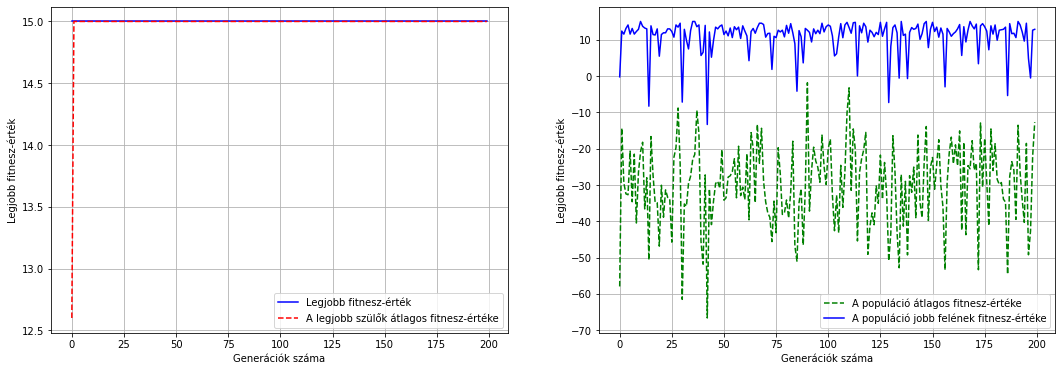

In [42]:
#Ábrázoljuk a populáció javulását grafikonon
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
ax[0].plot(best_fitnesses, 'b-', label='Legjobb fitnesz-érték')
ax[0].plot(avg_best, 'r--', label='A legjobb szülők átlagos fitnesz-értéke')
ax[1].plot(avg_pop, 'g--', label='A populáció átlagos fitnesz-értéke')
ax[1].plot(avg_half, 'b-', label='A populáció jobb felének fitnesz-értéke')

for aa in ax:
    aa.set_xlabel('Generációk száma')
    aa.set_ylabel('Legjobb fitnesz-érték')
    aa.grid(True)
    aa.legend()

(15.0, None)

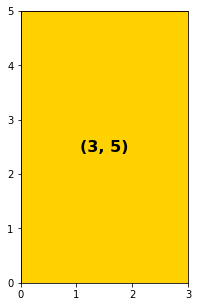

In [43]:
#Melyik a legjobb egyed?
best_fitnesses[-1], plot_area(best_parents[0])

Egyértelműen belátható, hogy az algoritmus a legjobb egyedet állította elő. A következő példákban ennél bonyolultabb eseteket vizsgálunk.